## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries

In [1]:
import matplotlib.pyplot as plt
import IPython.display as ipd

import numpy as np
import torch

from hparams import create_hparams
from train import load_model
from text import text_to_sequence

In [2]:
%matplotlib inline

def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='lower', 
                       interpolation='none')
    return fig, axes

#### Setup hparams

In [3]:
hparams = create_hparams()
hparams["sampling_rate"] = 22050

#### Load model from checkpoint

In [4]:
checkpoint_path = "tacotron2_ljspeech_50k.pt"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
# _ = model.cuda().eval().half()

<All keys matched successfully>

#### Prepare text input

In [5]:
text = "A spectrogram is a visual representation of a signal's frequencies as it varies with time."
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long()

#### Decode text input and plot results

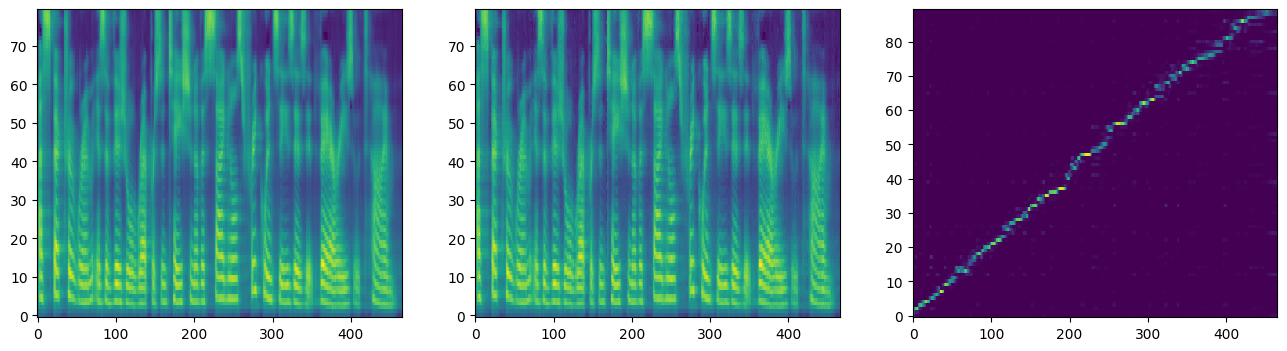

In [6]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
fig, axes = plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

# plt.savefig("generated_spectrograms.png")
plt.show()

#### Synthesize audio using Griffin-Lim

In [7]:
from librosa.feature.inverse import mel_to_audio
from scipy.io.wavfile import write

mel_spectrogram = mel_outputs_postnet.float().data.cpu().numpy()[0]

audio = mel_to_audio(
    M = mel_spectrogram,
    sr = hparams["sampling_rate"],
    n_fft = hparams["filter_length"],
    hop_length = hparams["hop_length"],
    win_length = hparams["win_length"],
    fmin = hparams["mel_fmin"],
    fmax = hparams["mel_fmax"]
)

ipd.Audio(audio, rate=hparams["sampling_rate"])
# write(filename="samples/audio_griffinlim.wav", data=audio, rate=hparams["sampling_rate"])

#### Synthesize audio using Waveglow

In [9]:
import sys
sys.path.append('waveglow/')

waveglow_path = 'waveglow_256channels.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda()

with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)

ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams["sampling_rate"])
# write(filename="samples/audio_waveglow.wav", data=audio[0].cpu().numpy()*18, rate=hparams["sampling_rate"])

#### Synthesize audio using Vocos

In [ ]:
!pip install vocos

In [10]:
from vocos import Vocos

vocos = Vocos.from_pretrained("charactr/vocos-mel-24khz")

# Convert to 100-mel spectrogram by padding
pad = torch.nn.ReflectionPad2d((0,0,0,20))

# Convert to 100-mel spectrogram by scaling
spectrogram = mel_outputs.permute(0, 2, 1)
spectrogram = torch.nn.functional.interpolate(spectrogram, size=100, mode="nearest")
spectrogram = spectrogram.permute(0, 2, 1)

audio = vocos.decode(pad(mel_outputs).cpu()) # spectrogram.cpu()

ipd.Audio(audio.numpy(), rate=26200) # hparams["sampling_rate"])
# write(filename="samples/audio_vocos.wav", data=audio[0].numpy(), rate=26200)

#### Synthesize audio using MelGAN / WaveGAN / HiFiGAN / Wavegrad / ~DiffWave~ / BigVSAN 

Pick your favorite and start implementing!